# 6. Model training

With all features successfully extracted, the final step is to pick and train the machine learning model that would classify each word in a report as being a part of P&L statement, located above or below it. 

# Table of Contents

1. [Final-pre-processing](#Final-pre-processing)
    1. [Load data](#Load-data)
    1. [Split into training and testing sets](#Split-into-training-and-testing-sets)
    1. [Build downsized testing sets](#Build-downsized-testing-sets)
    1. [Merge labels](#Merge-labels)
    1. [Normalize inputs](#Normalize-inputs)
1. [Pick the model](#Pick-the-model)
    1. [Multinomial Naive Bayes](#Multinomial-Naive-Bayes)
    1. [Support Vector Machines (SVM)](#Support-Vector-Machines-(SVM))  
    1. [Stochastic Gradient Descent (SGD)](#Stochastic-Gradient-Descent-(SGD))
1. [Pick merged vs. unmerged labels](#Pick-merged-vs.-unmerged-labels)
1. [Pick the training set size](#Pick-the-training-set-size)
    1. [Full size](#Full-size)
    1. [0.1% sample](#0.1%-sample)
1. [Save the winning model](#Save-the-winning-model)

In [1]:
import numpy as np
import pandas as pd
import sys
from IPython.display import display
from scipy.sparse import csr_matrix, csc_matrix, save_npz, load_npz, hstack
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, f1_score, fbeta_score, precision_score, recall_score, make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
%matplotlib inline

## Final pre-processing

There are just a couple final pre-processing steps that are reqiured to streamline the model training.

### Load data

In [2]:
data = np.load('files/data.npz', allow_pickle=True)

In [3]:
data.files

['company', 'train', 'labels', 'words']

In [4]:
X = load_npz('files/X.npz')

### Split into training and testing sets

In [5]:
def split_on_bool(array, criteria):
    return array[criteria].copy(), array[~criteria].copy()

In [6]:
# split the labels into training and testing sets
y_train, y_test = split_on_bool(data['labels'], data['train'])

In [7]:
# split the inputs into training and testing sets
X_train, X_test = split_on_bool(X, data['train'])

### Build downsized testing sets

With our data set consisting of almost 24 million entries, training some of the models might be quite challenging. Luckily, if we think about the kind of data that is encoded in our features, there is a lot of feature similarity across the co-located entries. More specifically, when it comes to any pair of two adjacent words, the maximum difference between their feature values might be at most a count of `1` for just one of the first 100 features (i.e. total counts for the 100-word window above the current word) and at most a `1` for one of the remaining 100 features (i.e. total counts for the 100-word window below the current word). So, theoretically, while training on all entries will drive additional precision, for the purposes of picking the right model we can first explore a down-sized version (e.g., a randomly pulled set of 1% of entries - or maybe even 0.1%). And then, when the right model choice is made, we can try and re-train it on the full data set.

In [8]:
def reduce_sample(X, y, percent):
    '''Randomly pulls a predefined percent of entries from a given data set.'''
    
    filt = np.random.rand(X.shape[0]) < percent
    return X[filt], y[filt]

In [9]:
# generate a sample of 1%
X_train_1_prc, y_train_1_prc = reduce_sample(X_train, y_train, 0.01)

In [10]:
# check the shapes
X_train_1_prc.shape, y_train_1_prc.shape

((186238, 200), (186238,))

In [11]:
# generate a sample of 0.1%
X_train_01_prc, y_train_01_prc = reduce_sample(X_train, y_train, 0.001)

In [12]:
# check the shapes
X_train_01_prc.shape, y_train_01_prc.shape

((18631, 200), (18631,))

### Merge labels

While the original data includes 3 labels (1 = above P&L statement, 2 = within P&L statement, 3 = below P&L statement), we theoretically only need 2 (P&L vs. non-P&L). However, it is not a clear cut, because, if categories 1 and 3 are significanly different, merging the labels might create additional "confusion" for the model. To verify which option is better, I would need to have a version of the label set with categories 1 and 3 "merged" in one label.

In [13]:
def substitute_label(y, old_label, new_label):
    '''Substitutes an existing label with a different one.'''
    
    new_y = y.copy()
    new_y[new_y==old_label] = new_label
    
    return new_y

In [14]:
# verify the unique labels
np.unique(y_train_1_prc, return_counts=True)

(array([1, 2, 3]), array([113735,    877,  71626]))

In [15]:
# merge the labels
y_train_1_prc_merged = substitute_label(y_train_1_prc, 3, 1)
y_test_merged = substitute_label(y_test, 3, 1)

In [16]:
# verify the unique labels after merging
np.unique(y_train_1_prc_merged, return_counts=True)

(array([1, 2]), array([185361,    877]))

### Normalize inputs<a id='norm'></a>

Some machine learning models (e.g. SVM) would require scaling of the data. For these purposes, I would use `sklearn`'s `MaxAbsScaler`. The reason for this choice is that some of the more widely used scalers (e.g. `StandardScaler` or `MinMaxScaler`) don't work as well with sparse data:

Here are some details from [sklearn documentation](#https://scikit-learn.org/stable/modules/preprocessing.html#scaling-sparse-data):
> Centering sparse data would destroy the sparseness structure in the data, and thus rarely is a sensible thing to do. However, it can make sense to scale sparse inputs, especially if features are on different scales.
> `MaxAbsScaler` and `maxabs_scale` were specifically designed for scaling sparse data, and are the recommended way to go about this.

In [17]:
maxabs = MaxAbsScaler()

In [18]:
# scale the training set
X_train_1_prc_scaled = maxabs.fit_transform(X_train_1_prc)

In [19]:
# scale the testing set
X_test_scaled = maxabs.transform(X_test)

## Pick the model

Now we're ready to pick the right model. Given the task at hand, I would like to explore three potential options:
1. *Naive Bayes* - usually scales very well and often performs well in practice
2. *Support Vector Machine* - can pick up on more complex relationships, but is notoriously hard to scale 
3. *Stochastic Gradient Descent* - linear models are sometimes very performant, while also easier to understand

To make sure that all 3 models can be trained in reasonable amount of time, temporarily reducing the data set to at least 1% of the orinal size for this step would be really helpful. As discussed before, given the structure of the data this should still be a relatively representative sample of the underlying data.

Our key KPI for picking the best model would be an **F-beta score of label 2** with beta value higher than 1 (e.g., 5). The reasons for this choice are three-fold:
1. One of the categories (more specifically, our target one - label 2) is dramatically smaller in size than the other two. Because of that, accuracy won't be a good measure, as even getting all label 2 predictions wrong can still coincide with high accuracy on the overall data set
1. We care much more about recall in this case than precision. In other words, while having too many false positives is somewhat of a problem, it can be still dealt with to some extent later through additional data processing (e.g, by only picking the predicting label 2s that are adjacent to each other and collectively have the highest probability scores). False negatives are a much larger problem though, as they essentially mean some of the P&L data will be lost for further analysis. Therefore, a simple F1 score is not gonna be enough, as it assumes equal importance of precision and recall
1. We don't really care about precision and recall between categories 1 and 3, so if some 1s are classified as 3s or vice versa, this should not be a problem. Therefore, we really need to look at the score of our most important label only (label 2). Later in this notebook, we will explore whether we can even merge labels 1 and 3 (in which case we would have a binary label, and the overall F-beta would work as well).

For the purposes of this project, I'll target a minimum F-beta value of 70% as my model acceptance criteria.

### Multinomial Naive Bayes

In [20]:
def plot_predictions_for_label_value(predictions, labels, label, ax=None):
    
    if not ax:
        ax = plt.gca()
        
    values, counts = np.unique(predictions[labels==label], return_counts=True)
    percents = counts / counts.sum()
    
    ax.bar(x=values, height=percents)
    ax.set_title('True label: {}'.format(label), fontsize=12, fontweight='bold')
    ax.set_xlabel('Predicted label', fontsize=12)
    ax.set_ylim(0, 1)
    ax.set_xticks(values);

In [21]:
def get_scores(y_test, y_pred):
    
    print('Accuracy score: {}'.format(accuracy_score(y_test, y_pred)))
    display(pd.DataFrame({'Label': np.unique(y_test),
                          'F1': f1_score(y_test, y_pred, average=None),
                          'F_beta_5': fbeta_score(y_test, y_pred, beta=5, average=None),
                          'F_beta_05': fbeta_score(y_test, y_pred, beta=0.5, average=None),
                          'Recall': recall_score(y_test, y_pred, average=None),
                          'Precision': precision_score(y_test, y_pred, average=None)}))
    
    labels = np.unique(y_test)
    fig, ax = plt.subplots(1, len(labels), figsize=(12, 4))
    fig.suptitle('Share of predicted values by true label', fontsize=14, fontweight='bold', y=1.01)
    for i, label in enumerate(labels):
        plot_predictions_for_label_value(y_pred, y_test, label, ax[i])

In [22]:
def clf_fit_predict(model, X_train, y_train, X_test, y_test):
    '''Fits the model to the training set, and estimates performance on the testing set.'''
    
    clf = model()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    get_scores(y_test, y_pred)
    
    return model

Accuracy score: 0.7199644326767207


,Label,F1,F_beta_5,F_beta_05,Recall,Precision
0,1,0.785355,0.754891,0.806511,0.752458,0.821259
1,2,0.159241,0.703979,0.105951,0.984685,0.086625
2,3,0.669264,0.668384,0.669837,0.668311,0.670220


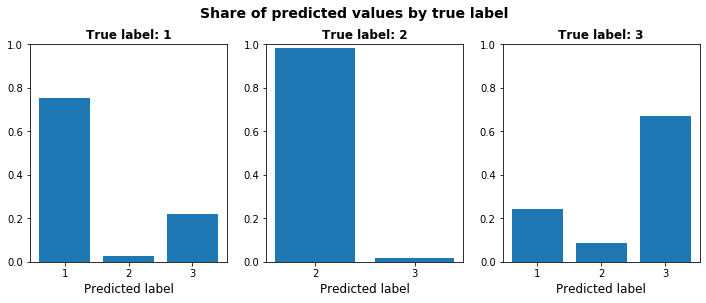

In [23]:
# fit the model and print the metrics
bayes_1_perc = clf_fit_predict(MultinomialNB, X_train_1_prc, y_train_1_prc, X_test, y_test)

### Support Vector Machines (SVM)

Regular SVM implementation turned out to not scale at all (even if left running for hours) with this dataset (even the 1% down-sampled version), which is explained well in [sklearn.svm.SVC documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html): 
> The implementation is based on libsvm. The fit time scales at least quadratically with the number of samples and may be impractical beyond tens of thousands of samples.

Instead, as suggested by the same documentation, I will use a `LinearSVC` model that scales better with the data.

Also, it is crucial to tune SVM's hyperparameters, so I will be using Grid Search with it right away.

In [24]:
def grid_search_fit_predict(model, param_grid, scorer, X_train, y_train, X_test, y_test):
    '''Runs the grid search on the training set, and estimates performance on the testing set.'''
    
    clf = model()
    grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, scoring=scorer, cv=5)
    grid_search.fit(X_train, y_train)
    
    print('Best model parameters: {}'.format(grid_search.best_params_))
    
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    get_scores(y_test, y_pred)
    
    return best_model

In [25]:
# define the scorer
f5_scorer = make_scorer(fbeta_score, beta=5, average=None, labels=[2])

In [26]:
# define the parameter grid for Grid Search
param_grid = {
    'tol': [1e-3, 1e-4, 1e-5],
    'C': [0.1, 1.0, 10.0],
    'dual': [True, False]
}

/Users/ayarmak/anaconda3/envs/py3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Best model parameters: {'C': 10.0, 'dual': False, 'tol': 0.001}
Accuracy score: 0.8030210859531992


,Label,F1,F_beta_5,F_beta_05,Recall,Precision
0,1,0.833164,0.815959,0.844741,0.814557,0.852640
1,2,0.602144,0.481387,0.719453,0.473474,0.826842
2,3,0.762529,0.787722,0.747000,0.789897,0.736994


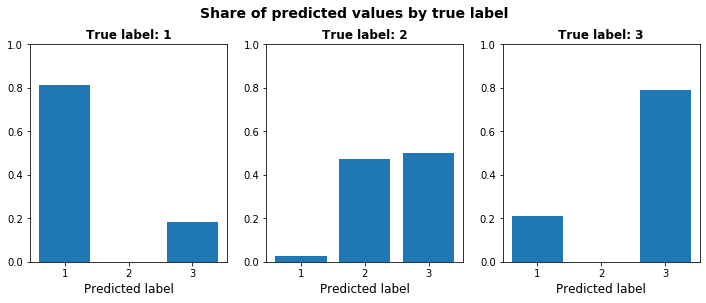

In [27]:
# fit the model and print the metrics
svm = grid_search_fit_predict(LinearSVC, param_grid, f5_scorer, 
                              X_train_1_prc_scaled, y_train_1_prc, X_test_scaled, y_test)

### Stochastic Gradient Descent (SGD)

Given the number of potential parameter options for SGD, I will be using Grid Search for it as well.

In [28]:
# define the parameter grid for Grid Search
param_grid = {
    'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3], # learning rate
    'loss': ['log', 'modified_huber', 'perceptron'], 
    'penalty': ['l1', 'l2']
}

/Users/ayarmak/anaconda3/envs/py3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Best model parameters: {'alpha': 0.0001, 'loss': 'perceptron', 'penalty': 'l2'}
Accuracy score: 0.7722351125929534


,Label,F1,F_beta_5,F_beta_05,Recall,Precision
0,1,0.819575,0.853837,0.798742,0.856822,0.785432
1,2,0.587951,0.621850,0.567831,0.624852,0.555166
2,3,0.695696,0.651502,0.727787,0.648071,0.750877


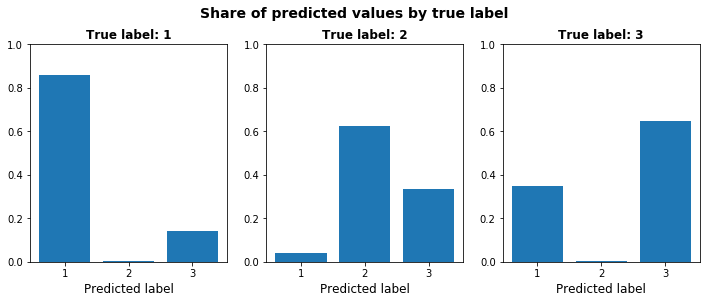

In [29]:
# fit the model and print the metrics
sgd = grid_search_fit_predict(SGDClassifier, param_grid, f5_scorer, 
                              X_train_1_prc_scaled, y_train_1_prc, X_test_scaled, y_test)

As we can see, Multinomial Naive Bayes was the only model that was able to achieve our target F-beta of 70%. Now let's see if we can improve on this result.

## Pick merged vs. unmerged labels

First, I would like to explore if merging 1s and 3s in one category might improve model performance.

Accuracy score: 0.9370218310179224


,Label,F1,F_beta_5,F_beta_05,Recall,Precision
0,1,0.967323,0.939053,0.986630,0.936772,0.999934
1,2,0.133690,0.662215,0.088025,0.987566,0.071698


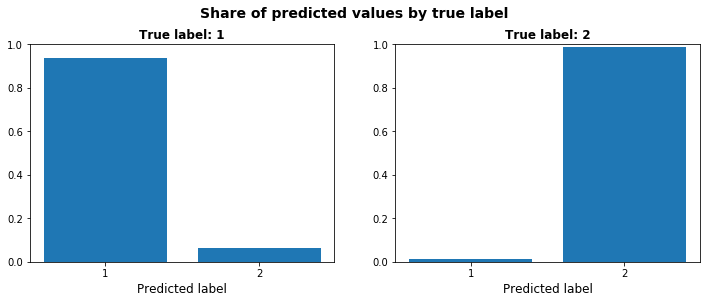

In [32]:
# fit the model and print the metrics
bayes_1_perc_merged = clf_fit_predict(MultinomialNB, X_train_1_prc, y_train_1_prc_merged, X_test, y_test_merged)

Interestingly, while accuracy increases dramatically after merging, F-beta actually degrades after this operation. Which probably means that merged categories are significantly different from each other to justify the split and avoid the model from being "confused" by a non-homogenous category.

## Pick the training set size

Now I would like to explore if changing the size of the data set can drive additional improvement in model performance. As a reminder, we downsized the dataset to 1% of the entries for the model selection purposes. Now that we clarified the best model for our purposes (Multinomial Naive Bayes), we can try to train it on a larger dataset. Luckily, Naive Bayes also tends to scale much better than some other models, so this exercise actually have higher chances for success.

### Full size

Accuracy score: 0.7211591389102865


,Label,F1,F_beta_5,F_beta_05,Recall,Precision
0,1,0.786019,0.757253,0.805918,0.754951,0.819754
1,2,0.164430,0.711655,0.109634,0.984764,0.089704
2,3,0.669290,0.667718,0.670316,0.667587,0.671002


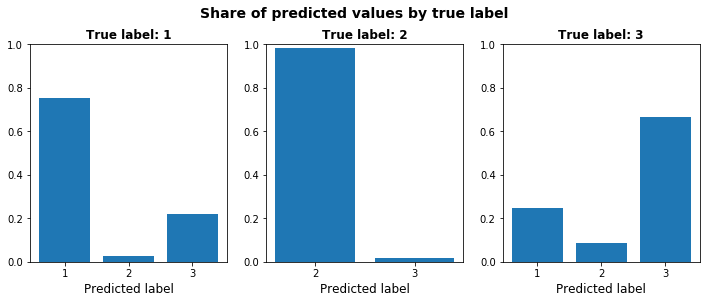

In [33]:
# fit the model and print the metrics
bayes_full = clf_fit_predict(MultinomialNB, X_train, y_train, X_test, y_test)

### 0.1% sample

Accuracy score: 0.7172153070012388


,Label,F1,F_beta_5,F_beta_05,Recall,Precision
0,1,0.785279,0.757775,0.804254,0.755569,0.817421
1,2,0.151082,0.692846,0.100170,0.988119,0.081794
2,3,0.664636,0.657358,0.669453,0.656759,0.672704


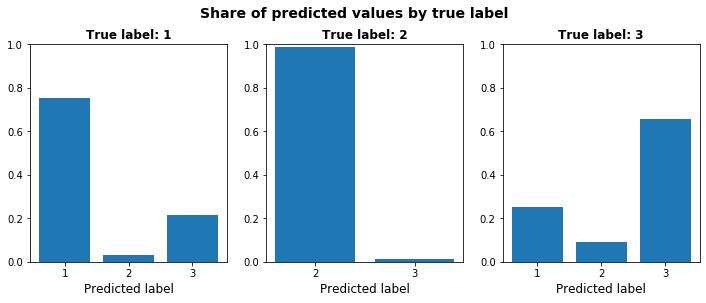

In [34]:
# fit the model and print the metrics
bayes_01_perc = clf_fit_predict(MultinomialNB, X_train_01_prc, y_train_01_prc, X_test, y_test)

As we can see, Multinomial Naive Bayes trained on the full data set turned out to be the winner among all the options that we explored in this project. It not only achieved a target F-beta of 70% for label 2, but also surpassed it to reach 71%.

## Save the winning model

In [35]:
from joblib import dump, load
dump(bayes_full, 'files/bayes_full.joblib')

['files/bayes_full.joblib']